# **Coursera Capstone**
### ML Truter

*This notebook documents the final capstone project of the IBM Data Science Professional Certificate*

In [1]:
# Modules for data wrangling
import numpy as np
import pandas as pd

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # Map plotting

# Module for other functionalty
import os
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Modules for model building
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize # Not usefull method to use in my opinion
from sklearn.preprocessing import MinMaxScaler # Not usefull method to use
import scipy.cluster.hierarchy as shc

# Settings for modules
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'canadian_cities.csv',
 'capstone_project.ipynb',
 'Capstone_The-Battle-of-the-Neighborhoods_Example.ipynb',
 'cluster_insights.xlsx',
 'cost_of_living_index.csv',
 'Geospatial_Coordinates.csv',
 'Neighborhood_Segmentation_Clustering.ipynb',
 'README.md',
 'test.py']

In [3]:
# Load data to be used
df_lcost = pd.read_csv('cost_of_living_index.csv') # Relative living cost metrics relative to New York (baseline = 100)
df_cities = pd.read_csv('canadian_cities.csv') 

In [4]:
# Data Cleaning and merging
# Filter out only canadian cities from the df_lcost df
df_temp = pd.DataFrame()
df_temp = df_lcost.drop('City', axis=1)

df_temp['City'] = df_lcost['City'].apply(lambda x: x.split(',')[0].strip())
df_temp['Country'] = df_lcost['City'].apply(lambda x: x.split(',')[1].strip())

# Only keep Canadian cities 
df_temp = df_temp[df_temp['Country'] == 'Canada']
df_temp['City'] = df_temp['City'].apply(lambda x:x.replace('Quebec City', 'Quebec')) 

# Clean location and population df (naming of Montreal and Quebec)
df_cities['city'] = df_cities['city'].apply(lambda x:x.replace('é', 'e').strip())

# Merge dataframes
df_can = pd.merge(left=df_temp, right=df_cities, left_on='City', right_on='city', how='inner')
df_can = df_can.drop(['city', 'country', 'capital', 'Country', 'iso2', 'population_proper'], axis=1).reset_index()

# Reorder the columns more logically
df_can = df_can[['City', 'admin', 'lat', 'lng', 'population', 'Cost of Living Index', 'Rent Index', 'Local Purchasing Power Index']]
df_can = df_can.rename(columns={'City':'city', 'population':'pop', 'Cost of Living Index':'living_indx', 'Rent Index':'rent_indx', 'Local Purchasing Power Index':'ppi'})

In [5]:
# Top 5 Cities in Canada in terms of PPI
df_can.sort_values('ppi', ascending=False).head(5)

,city,admin,lat,lng,pop,living_indx,rent_indx,ppi
18,Ottawa,Ontario,45.416667,-75.700000,1145000,62.88,30.26,144.70
13,Quebec,Québec,46.800000,-71.250000,624177,65.07,16.10,140.18
7,Red Deer,Alberta,52.266667,-113.800000,74857,67.42,23.58,140.16
5,Calgary,Alberta,51.083333,-114.083333,1110000,68.93,29.85,138.51
23,Kitchener,Ontario,43.446976,-80.472484,417001,58.93,25.38,129.74


In [6]:
# Augment current df with data from the Foursquare API
# Foursquare API user details
CLIENT_ID = 'O0LIFMUBGPNZ4Y5NSWWC23OFU0QM3QMDLX32UN42DOAXXLVB'
CLIENT_CODE = '2J5PWAOXJKSTRSTPZBJMCFP1QMNQUU5NNRGGNSR2R45AK5X3'
VERSION = '20180605'
URL_SEARCH = 'https://api.foursquare.com/v2/venues/search'
LIMIT = 100

def search_call_num_locs(city_lat, city_lng, radius, category_ids):
    """ Function that returns the number of venues within the specified radius as defined by the category ids."""
    
    params = dict(
      client_id=CLIENT_ID,
      client_secret=CLIENT_CODE,
      v=VERSION,
      ll='{}, {}'.format(city_lat, city_lng),
      radius=radius,
      intent='browse',
      categoryId=category_ids,
      limit=LIMIT
    )
    
    resp = requests.get(url=URL_SEARCH, params=params)
    data = json.loads(resp.text)
    num_venues = len(data['response']['venues'])
    return num_venues
    

In [66]:
city_locs = pd.DataFrame(columns=['city', 'admin', 'outdoor', 'food', 'work_opp', 'entertainment', 'remoteness'])

# Determine category ids of locations of interest (from: https://developer.foursquare.com/docs/resources/categories)

# List of outdoor locations of interest. Search for outdoor trails, ski trails, biking trails, outdoor gyms 
outdoor_loc_interest = ['4bf58dd8d48988d159941735', '4eb1c0f63b7b52c0e1adc2eb', '56aa371be4b08b9a8d57355e', '58daa1558bbb0b01f18ec203']
rad_outd = '30000' # Radius to search for outdoor locations (m) #20000
# Food locations of interest
food_loc = ['4d4b7105d754a06374d81259']
rad_food = '3000' 
# Work opportunity locations of interest. Tech startups, corporate cafeteria and corporate coffee shops
work_loc = ['4bf58dd8d48988d125941735', '54f4ba06498e2cf5561da814', '5665c7b9498e7d8a4f2c0f06']
rad_work = '35000' 
# Entertainment locations of interest. Nightlife: Beer bar, whisky bar, nightclubs, wine bar and pubs
entertainm_loc = ['4bf58dd8d48988d122941735', '4bf58dd8d48988d11b941735', '56aa371ce4b08b9a8d57356c', '4bf58dd8d48988d11f941735']
rad_enter = '15000'
# Remoteness locations of interest. Airports
remoteness_loc = ['4bf58dd8d48988d1eb931735']
rad_remoteness = '50000'

for i, city in df_can.iterrows(): # for each city

    num_outdoor_loc = search_call_num_locs(city['lat'], city['lng'], rad_outd, outdoor_loc_interest)
    
    num_food_loc = search_call_num_locs(city['lat'], city['lng'], rad_food, food_loc)

    num_work_loc = search_call_num_locs(city['lat'], city['lng'], rad_work, work_loc)

    num_enter_loc = search_call_num_locs(city['lat'], city['lng'], rad_enter, entertainm_loc)

    num_remoteness_loc = search_call_num_locs(city['lat'], city['lng'], rad_remoteness, remoteness_loc)
    
    # Add data to the dataframe
    city_locs = city_locs.append({'city':city['city'], 'admin':city['admin'], 'outdoor':num_outdoor_loc, 'food':num_food_loc, 'work_opp':num_work_loc, 'entertainment':num_enter_loc, 'remoteness':num_remoteness_loc}, ignore_index=True)
    

In [67]:
city_locs.shape

(24, 7)

In [68]:
# Merge city location data with the cost data
df_final = pd.merge(left=df_can, right=city_locs, on=['city', 'admin'], how='inner')
# Rename Windsor city name so they are distinguisable
df_final.loc[(df_final['city'] == 'Windsor') & (df_final['admin'] == 'Ontario'), 'city'] = 'Windsor ON'
df_final.loc[(df_final['city'] == 'Windsor') & (df_final['admin'] == 'Nova Scotia'), 'city'] = 'Windsor NS'

In [12]:
# Cluster the cities in some usefull way - this can be changed to change preferences
# All columns: ['city', 'admin', 'lat', 'lng', 'pop', 'living_indx', 'rent_indx', 'ppi', 'outdoor', 'food', 'work_opp', 'entertainment', 'remoteness', 'cluster']
cols_for_clustering = ['ppi', 'living_indx', 'rent_indx', 'outdoor', 'work_opp', 'entertainment', 'remoteness']
X = df_final[cols_for_clustering]

# Scale attributes in order to compare like-wise numbers
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

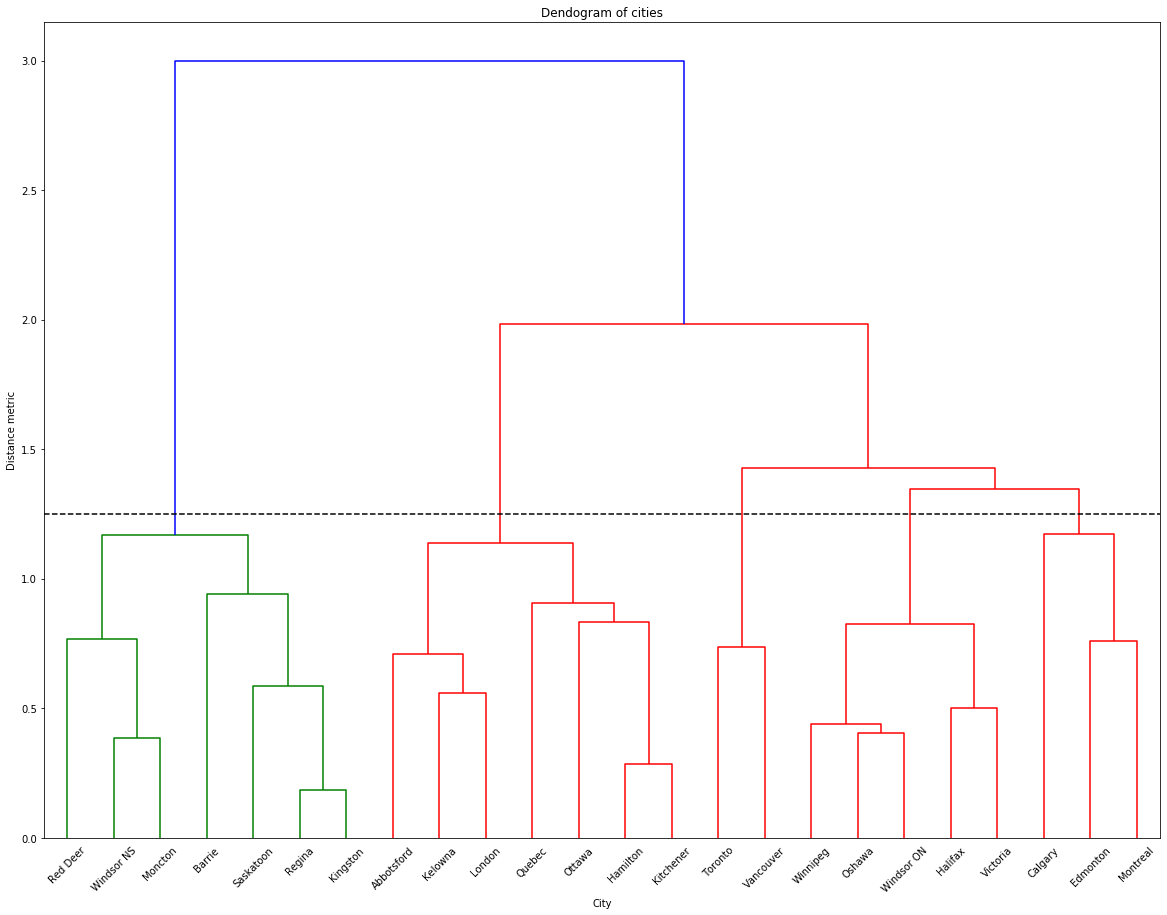

In [13]:
plt.figure(figsize=(20, 15))
plt.title('Dendogram of cities')
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'), labels=list(df_final['city']))
plt.xlabel('City')
plt.ylabel('Distance metric')
plt.axhline(y=1.25, color='k', linestyle='--')

In [17]:
# Train agglomerative cluster model
n_clust = 5 # Number of clusters, decided from the dendogram
mdl_cluster = AgglomerativeClustering(n_clusters=n_clust, affinity='euclidean', linkage='ward')
mdl_cluster.fit_predict(X_scaled)

# Add cluster values to the dataframe
df_clust = df_final
df_clust = df_clust[['city', 'admin', 'lat', 'lng'] + cols_for_clustering]
df_clust['cluster'] = mdl_cluster.labels_

C:\Users\Martin Truter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
# Resulting clusters for cities
df_final.describe()

,lat,lng,pop,living_indx,rent_indx,ppi
count,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,46.986548,-91.263747,8.247857e+05,65.884167,27.903333,116.852083
std,3.417750,20.843905,1.245533e+06,4.652763,7.429626,14.251336
min,42.301649,-123.343529,3.864000e+03,58.930000,16.100000,94.650000
25%,44.200000,-113.575000,1.700580e+05,63.082500,23.670000,108.457500
50%,45.798260,-80.861242,3.529380e+05,65.805000,26.610000,113.355000
75%,49.887500,-76.350000,8.052898e+05,68.577500,29.377500,127.732500
max,53.550000,-63.600000,5.213000e+06,77.370000,49.260000,144.700000


In [61]:
# Visualize results
# plt.figure(figsize=(12, 8))
# plt.scatter(x=df_clust['living_indx'], y=df_clust['remoteness'], c=df_clust['cluster'])

# Visualise the results in Folium 
# create map of New York using latitude and longitude values
can_lat = 55
can_lng = -93
map_canada = folium.Map(location=[can_lat, can_lng], zoom_start=3)

# Create different color for each cluster
clust_colors = ['#2c6fbb', '#02ab2e', '#9aae07', '#c04e01', '#929591']

# add markers to map
for lat, lng, city, cluster in zip(df_clust['lat'], df_clust['lng'], df_clust['city'], df_clust['cluster']):
    label = '{}, cluster: {}'.format(city, cluster)
    label = folium.Popup(label, parse_html=False, show=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=clust_colors[cluster],
        fill=True,
        fill_color=clust_colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada